In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_json('data_analysis.json')

# Scope

- Answer some of the basic questions that Radius finds generally useful
    - Fill Rate
    - Relevant Fill Rate
    - Cardinality of the fields for this sample of 1M
    
- Find something interesting in the data.

### Percentage of records are filled for each field

Both this and 'relevant_fill_rate' help us to understand what fields are filled less often than the rest.

You can see in the plot below that the `phone` field is only filled at ~60% of the time. This fact influenced the rest of my analysis. This fact, and the conversation in our phone interview about how incomplete data is of interest inspired me to try to figure out associations with phone fill rate in particular. 

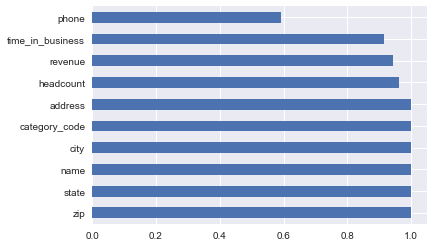

In [3]:
def is_filled(sr):
    nulls = sr.notnull()
    return nulls


filled = df.apply(is_filled)
mean = filled.mean()
mean.sort_values(ascending=False).plot(kind='barh')

### Percentage of Records That Have Relevant Value

This is very similar to the fill rate except that it's cleaned of any non relevant information; like the suggested ' ' empty string, but also some others (i.e. int(0)'s, and none strings like 'null')

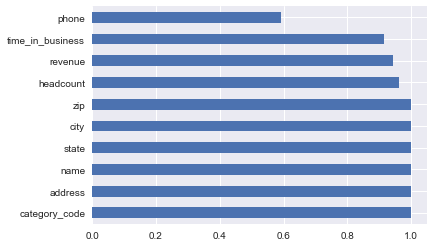

In [4]:
def is_relevant(r):
    """Generic relevancy function for most fields"""
    if any([
        r is None,
        r == 'null',
        r == 'none',
        r == 'None',
        r == 0,
        r == '0'
    ]):
        return False
    return True


def is_relevant_name(r):
    """Relevancy of an entry in `name` field"""
    if all([
        isinstance(r, basestring) and r.replace(' ', ''),
        r is not None,
        r != 'null',
        r != 'none'
    ]):
        return True
    return False


def make_relevant_matrix(df):
    """Make a boolean relevancy matrix
    
    `special_relevancy_functions` are different cases for different 
    columns
    """
    relevant = pd.DataFrame([])
    special_relevancy_functions = {
        'name': is_relevant_name,
        'headcount': is_relevant_name,
        'time_in_business': is_relevant_name
    }
    for col in df.columns:
        clean_func = special_relevancy_functions.get(col, is_relevant)
        relevant[col] = df[col].map(clean_func)
    return relevant


relevant = make_relevant_matrix(df)
relevant_mean = relevant.mean()
relevant_mean.sort_values(ascending=False).plot(kind='barh')

### Cardinality of Each Field (distinctness)

In [5]:
def cardinality(s):
    s = s[s.map(is_relevant)]
    return len(s.unique())


phone_cardinality = cardinality(df['phone'])
relevant_cardinality = df.agg(cardinality)

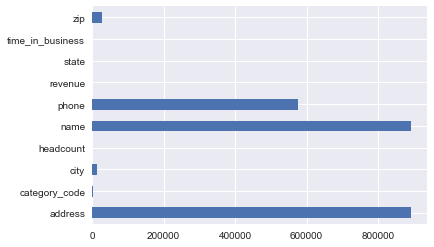

In [6]:
relevant_cardinality.plot(kind='barh')

### Notable Observations: 

Since one of the motivators for joining a service like Radius has to do with getting a "lead list".  I'm going to say it's fair to put value on getting pieces of information that allow one to contact the business entities.  The fields related to "contacting a business" are it's **name**, **address** and **phone number**.

I want to see how the other fields predict someone not filling in these fields with relevant information.

These probabilities will help us decide which business demographics to target to increase **relevant fill rate**.

##### a bit more cleaning to set up an analysis 

In [7]:
df_cleaned = df[relevant['revenue'] &\
                relevant['headcount'] &\
                relevant['category_code'] &\
                relevant['time_in_business']]

In [8]:
def make_naics_lookup():
    naics = pd.read_excel('2017 NAICS Structure with Change Indicator.xlsx', header=2)
    naics['2017 NAICS Code'] = naics['2017 NAICS Code'].map(lambda x: str(x))
    name_lookup = dict(naics[['2017 NAICS Code', '2017 NAICS Title']].to_dict('split')['data'])
    return name_lookup

name_lookup = make_naics_lookup()

In [9]:
df_cleaned['category_3_num'] = df_cleaned['category_code'].map(
    lambda x: name_lookup.get(
        x[:2], # the tier 2 industry
        name_lookup.get(
            x[:3])) # the tier 3 industry if 2 doesn't have a lookup
)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


##### split our data into predictors and targets

In [10]:
X = pd.get_dummies(df_cleaned[['category_3_num', 'headcount', 'time_in_business']])
y = df_cleaned['phone'].map(is_relevant)

assert y.shape[0] == X.shape[0]

Looks at Instances where phone was omitted as compared to 
- category
- headcount
- time in business

In [11]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

Try logistic regression to see what features contribute most to phone fill rate

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = LogisticRegression(solver='sag', n_jobs=-1)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
sorted_by_coeff = pd.DataFrame(
    sorted(zip(X.columns, model.coef_.ravel()),
           key=lambda x: abs(x[1]),
           reverse=True),
    columns=['feature_name', 'log_coeff']
)

### Notable Observations from building a model

Take a brief look at the coefficients and see what contributes most greatly to whether someone will include relevant phone number information. 

From below it looks like time_in_business = 0 and headcount = 0 result in a higher likelihood of filling out the phone field.  

*aside: To understand the coefficient in terms of probabilities I've had to go to https://stats.stackexchange.com/questions/20996/how-to-interpret-coefficients-from-a-logistic-regression*



In [14]:
sorted_by_coeff['log_odds'] = np.exp(sorted_by_coeff['log_coeff'])

In [15]:
sorted_by_coeff

,feature_name,log_coeff,log_odds
0,time_in_business_0,0.878576,2.407468
1,headcount_0,0.679926,1.973732
2,time_in_business_3-5 years,-0.231574,0.793284
3,time_in_business_6-10 years,-0.225408,0.798191
4,time_in_business_10+ years,-0.222909,0.800188
5,time_in_business_1-2 years,-0.198688,0.819806
6,category_3_num_Pipeline TransportationT,-0.195518,0.822409
7,category_3_num_Rail TransportationT,0.153937,1.166417
8,category_3_num_Transportation Equipment Manufa...,-0.131489,0.876789
9,"headcount_Over 1,000",-0.128363,0.879534


If you're 
- time in business is 0 and 
- headcount is 0 

you're  ~1.9 times as likely to enter a phone number. 

This feels right as well.  If I'm an entrepreneur just starting out with a business, looking for leads, being called by too many people is probably my last concern.  I'm probably more excited about getting access to so many other people's phone numbers in the process. 

If I'm not a company that's just starting out, this is probably less likely the case.  Looking at the time in business examples:
- 3-5 years 
- 6-10 years

Those companies are ~.85 times as likely to report their phone numbers than people that aren't in those categories.  

**But there are soo many features, especially for a logistic model!, let me try something a bit different**

I'm going to turn the categorical values into scalars to reduce the number of input variables and hopefully make these observations more interpretable.

In [16]:
df_cleaned

,address,category_code,city,headcount,name,phone,revenue,state,time_in_business,zip,category_3_num
0,10085 SCRIPPS RANCH CT STE A,44420000,SAN DIEGO,50 to 99,AMD CUSTOM,3123628000,$20 to 50 Million,CA,10+ years,92131,Building Material and Garden Equipment and Sup...
1,2566 SHALLOWFORD RD NE STE 104 # 302,31490000,ATLANTA,1 to 4,Real Hope Real Estate Inc,None,"Less Than $500,000",GA,10+ years,30345,Textile Product MillsT
2,212 E MAIN ST,53120000,NEOSHO,1 to 4,Jimmy Sexton Photography,4046331779,"Less Than $500,000",MO,10+ years,64850,Real Estate and Rental and LeasingT
3,6032 CHEROKEE DR,54000000,CINCINNATI,1 to 4,YOU'RE ART,4174513798,"Less Than $500,000",OH,10+ years,45243,"Professional, Scientific, and Technical ServicesT"
4,1315 N WOOSTER AVE,54100000,STRASBURG,1 to 4,Hayberg Restoration Network LLC,5135612584,"$500,000 to $1 Million",OH,10+ years,44680,"Professional, Scientific, and Technical ServicesT"
5,1521 AZALEA RD,23610000,MOBILE,5 to 9,Venzon Engineering,None,$2.5 to 5 Million,AL,6-10 years,36693,ConstructionT
6,23513 PLAYVIEW ST,54100000,SAINT CLAIR SHORES,1 to 4,Sunrise Solutions Inc,4082621271,$1 to 2.5 Million,MI,10+ years,48082,"Professional, Scientific, and Technical ServicesT"
7,178 BOOTHBAY RD,23611600,EDGECOMB,1 to 4,Discount Hauling LLC,None,"Less Than $500,000",ME,10+ years,04556,ConstructionT
8,7 HAZZARD ST,56000000,WEST PALM BEACH,1 to 4,Knight Equestrian Books,None,"Less Than $500,000",FL,10+ years,33406,Administrative and Support and Waste Managemen...
13,9200 KEYSTONE XING STE 150,54000000,INDIANAPOLIS,20 to 49,St Mary Magdalen Parish,None,"Less Than $500,000",IN,1-2 years,46240,"Professional, Scientific, and Technical ServicesT"


In [17]:
df_cleaned['time_in_business'].unique()

array([u'10+ years', u'6-10 years', u'1-2 years', u'3-5 years', u'0'], dtype=object)

In [18]:
df_cleaned['headcount'].unique()

array([u'50 to 99', u'1 to 4', u'5 to 9', u'20 to 49', u'10 to 19',
       u'100 to 249', u'250 to 499', u'500 to 999', u'Over 1,000', u'0'], dtype=object)

In [19]:
lookup = dict(zip(df_cleaned['time_in_business'].unique(), [
    None, # we won't use 10 + since we can't say what the length of time is :-/
    8.,
    1.5,
    4,
    0
]))

def make_time_in_business_scalar(entry):
    return lookup.get(entry, None)

headcount_lookup = dict(zip(df_cleaned['headcount'].unique(),
                            [75., 2.5, 6.5, 34.5, 14.5, 74.5, 374.5, 749.5, None, 0]))

def make_headcount_into_scalar(entry):
    return headcount_lookup.get(entry, None)

In [20]:
df_cleaned['time_in_business_scalar'] = df_cleaned['time_in_business'].map(make_time_in_business_scalar)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_cleaned['headcount_scalar'] = df_cleaned['headcount'].map(make_headcount_into_scalar)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
X = df_cleaned[['time_in_business_scalar', 'headcount_scalar']]
y = df_cleaned['phone'].map(is_relevant)
X = X.dropna()
y = y[X.index]
assert y.shape[0] == X.shape[0]

Because I'm using 'saga' I will scale the data to between 0 and 1

In [24]:
model = LogisticRegression()

In [25]:
# notice scaling
model.fit(X/X.max(), y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
model.coef_

array([[ 0.00127264, -0.00241593]])

very little association.  I should have looked at this first

### Conclusion

Using Logistic Regression I wasn't able to find any strong associations beyond whether or not a company was just starting out.  

I did find that companies with a timeline_in_business of 0 or headcount of 0 are positively associated with phone field fill rates. 

In hindsight, having found such a small (or none) signal I'm thinking the next step is to do this process again but for each business category. 

With a quick look below:

In [58]:
one_category = df_cleaned[df_cleaned['category_code'] == '44420000']

In [79]:
X = one_category['time_in_business_scalar']
X = X.dropna()

y = relevant['phone'][X.index]

assert y.shape[0] == X.shape[0]

In [81]:
X = X.reshape(-1, 1)
model.fit(X/X.max(), y)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [82]:
model.coef_

array([[ 0.16289633]])

There is a stronger association found with headcount within one of our categories.

With more time I would make models within each industry.

This is just a starting point!